In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrected import

train_dir = '../data/dataset/train'
validation_dir = '../data/dataset/validation'
batch_size = 32
img_width, img_height = 180, 180

In [3]:
# Use ImageDataGenerator to preprocess and augment training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen

In [4]:

# Only rescale validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1. / 255)

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # 'binary' for binary classification (e.g., 'occupied' vs 'empty')
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 444 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [5]:
# Print number of samples in each directory
num_train_samples = train_generator.samples
num_val_samples = validation_generator.samples

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")

Number of training samples: 444
Number of validation samples: 72


In [8]:
# Calculate steps per epoch
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

In [10]:
# Define the model with Dropout and L2 Regularization
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # 'binary_crossentropy' for binary classification
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 20, 20, 128)      

2024-05-28 11:03:37.262846: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.
2024-05-28 11:03:37.279966: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21233664 exceeds 10% of free system memory.


In [13]:
epochs = 100

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]  # Add early stopping to the training process
)

# Define the directory path to save the model
save_dir = '../data/model/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the model to the specified path
model.save('../data/model/trained_model_jupyter.h5', save_format='h5')

Epoch 1/100
13/13 [==============================] - 14s 1s/step - loss: 0.0745 - accuracy: 0.9951 - val_loss: 0.2049 - val_accuracy: 0.8906
Epoch 2/100
13/13 [==============================] - 13s 1s/step - loss: 0.0740 - accuracy: 0.9879 - val_loss: 0.3062 - val_accuracy: 0.9375
Epoch 3/100
13/13 [==============================] - 13s 985ms/step - loss: 0.0705 - accuracy: 0.9976 - val_loss: 0.1995 - val_accuracy: 0.9531
Epoch 4/100
13/13 [==============================] - 23s 2s/step - loss: 0.0586 - accuracy: 0.9951 - val_loss: 0.1512 - val_accuracy: 0.9531
Epoch 5/100
13/13 [==============================] - 16s 1s/step - loss: 0.0354 - accuracy: 1.0000 - val_loss: 0.2048 - val_accuracy: 0.9531
Epoch 6/100
13/13 [==============================] - 14s 1s/step - loss: 0.0441 - accuracy: 0.9928 - val_loss: 0.1472 - val_accuracy: 0.9531
Epoch 7/100
13/13 [==============================] - 18s 1s/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.1716 - val_accuracy: 0.9531
Epoch 8/10

/home/abduraxmon/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


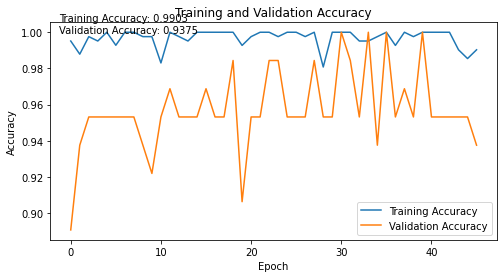

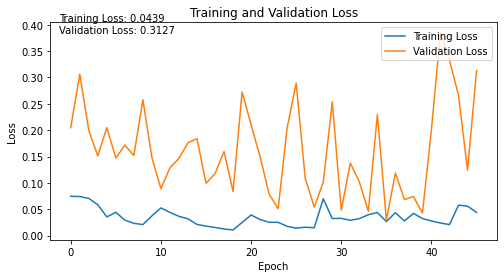

In [15]:
import os

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Use the length of the accuracy list to handle early stopping

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.text(0.02, 0.95, f'Training Accuracy: {acc[-1]:.4f}\nValidation Accuracy: {val_acc[-1]:.4f}',
         color='black', fontsize=10, transform=plt.gca().transAxes, ha='left')
plt.savefig(os.path.join('../data/images/graphs', 'accuracy_plot_jupyter.png'))
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.text(0.02, 0.95, f'Training Loss: {loss[-1]:.4f}\nValidation Loss: {val_loss[-1]:.4f}',
         color='black', fontsize=10, transform=plt.gca().transAxes, ha='left')
plt.savefig(os.path.join('../data/images/graphs', 'loss_plot_jupyter.png'))
plt.show()